In [256]:
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
import matplotlib.pyplot as plt
import shapely as shp
import numpy as np
from scipy.interpolate import griddata
from rasterio.warp import calculate_default_transform

# Read in the data and print some descriptions

In [2]:
INPUT_FILE = "data/BedrockP.shp"
bedrock_data = gpd.read_file(INPUT_FILE)

In [11]:
bedrock_data.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 126°W to 120°W and NAD83 by country
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1]:
x = 2

In [12]:
bedrock_data.describe(percentiles=[])

,gid,area_m2
count,1596.000000,1.596000e+03
mean,29576.919173,4.794685e+07
std,8030.144529,4.016358e+08
min,1351.000000,9.322000e+03
50%,33789.000000,2.685560e+06
max,35327.000000,1.343996e+10


In [13]:
bedrock_data.describe(percentiles=[], include='object')

,upid,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,mem_phase,rock_class,...,belt,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org
count,1596,1596,1596,1596,1596,1184,1036,443,76,1596,...,1596,1596,240,240,1596,1596,1596,1596,1596,1596
unique,1596,205,8,19,52,95,36,52,16,5,...,2,12,5,3,4,15,15,2,1,1
top,680ddc15,MiPlCvb,Mesozoic,Cretaceous,Lower Cretaceous,Bridge River Complex,Bridge River Complex,Powell Creek Formation,volcanic facies,sedimentary rocks,...,Coast,Overlap,Tyaughton-Methow,Upper Jurassic to Lower Cretaceous,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey
freq,1,64,803,425,224,126,126,43,11,556,...,1057,502,211,211,1098,574,574,1098,1596,1596


In [11]:
x = True
a = 1 if x else 2
print(a)

1


In [14]:
def printLists(listToPrint, maxLineLength=120, sep='||'):
    '''
    small function for printing list in a way that is a bit easier to read

    listToPrint {list}
    maxLineLength {int}:120
    sep {str}: '||'
    '''
    startSep = sep + ' '
    varSep = ' ' + sep + ' '
    lineToPrint = startSep

    for var in listToPrint:
        testLength = len(var) + len(lineToPrint) + len(varSep)
        if testLength <= maxLineLength:
            lineToPrint = lineToPrint + var + varSep
        else:
            print(lineToPrint)
            lineToPrint = startSep + var
    print(lineToPrint)
    
def printDictOfLists(dict, keys, maxLineLength=120, varSep='||', keySep='\n--------'):
    '''
    small function for printing list in a way that is a bit easier to read

    dict {dict}: expecting the values to be lists
    keys {list}: pass 1 or more keys in a list
    maxLineLength {int}:120
    varSep {str}: '||'
    keySep {str}: '\n--------'
    '''
    for key in keys:
        print(key, keySep)
        printLists(dict[key], maxLineLength=maxLineLength, sep=varSep)
        print('\n')

In [15]:
printLists(bedrock_data.columns.tolist(), maxLineLength=80)

|| gid || upid || area_m2 || strat_unit || era || period || strat_age || 
|| strat_namegp_suite || fm_lithodm || mem_phase || rock_class || rock_type || 
|| rk_charunit_desc || age_max || age_min || belt || terrane || basin || 
|| basin_ageproject || src_url || src_ref_s || map_comp || edit_date || 
|| pub_orggeometry || 


In [32]:
categCols = [col for col in bedrock_data.columns.tolist() if col not in ['gid', 'upid', 'area_m2', 'geometry']]
categoryDesc = dict()
for key in categCols:
    categoryDesc[key] = bedrock_data[key].unique().tolist()
printDictOfLists(categoryDesc, ['rock_type', 'rock_class'])

rock_type 
--------
|| coarse volcaniclastic and pyroclastic volcanic rocks || marine sedimentary and volcanic rocks || 
|| mudstone, siltstone, shale fine clastic sedimentary rocksbasaltic volcanic rocks || undivided sedimentary rocks || 
|| andesitic volcanic rocksfeldspar porphyritic intrusive rocks || granodioritic intrusive rocks || ultramafic rocks || 
|| quartz dioritic intrusive rocksgranite, alkali feldspar granite intrusive rocks || serpentinite ultramafic rocks || 
|| coarse clastic sedimentary rocksundivided volcanic rocks || dioritic intrusive rocks || 
|| greenstone, greenschist metamorphic rocksorthogneiss metamorphic rocks || 
|| argillite, greywacke, wacke, conglomerate turbiditesquartz monzonitic intrusive rocks || 
|| calc-alkaline volcanic rocksmid amphibolite/andalusite grade metamorphic rocks || rhyolite, felsic volcanic rocks || 
|| conglomerate, coarse clastic sedimentary rocksmixed volcanic and sedimentary rocks || 
|| lower amphibolite/kyanite grade metamorphi

# Create buffer shapes to get max bounds for raster

In [33]:
granodioriteData = bedrock_data.loc[bedrock_data['rock_type'] == 'granodioritic intrusive rocks']
ultramaficData = bedrock_data.loc[bedrock_data['rock_class'] == 'ultramafic rocks']

In [34]:
granodioriteData2 = granodioriteData[['rock_type', 'geometry']].dissolve(by='rock_type', 
                                                                         aggfunc='first', as_index=False)
ultramaficData2 = ultramaficData[['rock_class', 'geometry']].dissolve(by='rock_class', 
                                                                      aggfunc='first', as_index=False)

In [36]:
granodioriteData2.bounds

,minx,miny,maxx,maxy
0,380280.375762,5.489945e+06,669150.28474,5.722697e+06


In [38]:
ultramaficData2.bounds

,minx,miny,maxx,maxy
0,502510.164453,5.533123e+06,659106.451361,5.719946e+06


In [39]:
ultramaficData2.geometry.bounds

,minx,miny,maxx,maxy
0,502510.164453,5.533123e+06,659106.451361,5.719946e+06


In [40]:
ultumBuffer11K = ultramaficData2.buffer(11000)
granoBuffer11K = granodioriteData2.buffer(11000)

In [41]:
ultumBuffer11K.bounds

,minx,miny,maxx,maxy
0,491522.194408,5.522125e+06,670103.434455,5.730940e+06


In [42]:
granoBuffer11K.bounds

,minx,miny,maxx,maxy
0,369281.173104,5.478946e+06,680149.712176,5.733697e+06


In [60]:
projBounds = ultumBuffer11K.boundary - granoBuffer11K.boundary
projBounds.bounds

,minx,miny,maxx,maxy
0,491522.194408,5.522125e+06,670103.434455,5.730940e+06


# Create an empty raster for calculating the distance to shapes of interest

### Reading in a raster and see what it gives us so I can figure out how the raster fileformat works

In [79]:
rData = rio.open('data/granoRaster.tif')

In [87]:
print('width: ', rData.width, ' | height: ', rData.height)
print('dtypes: ', {i: dtype for i, dtype in zip(rData.indexes, rData.dtypes)})
print('bounds: ', rData.bounds)
print('Transform: ', rData.transform)
print('crs: ', rData.crs)

width:  2889  | height:  2328
dtypes:  {1: 'float32'}
bounds:  BoundingBox(left=380280.3758, bottom=5489897.4544, right=669180.3758, top=5722697.4544)
Transform:  | 100.00, 0.00, 380280.38|
| 0.00,-100.00, 5722697.45|
| 0.00, 0.00, 1.00|
crs:  EPSG:26910


In [88]:
band1 = rData.read(1)

In [108]:
band1[0][0]

-999.0

In [109]:
xcord, ycord = (rData.bounds.left + 10000, rData.bounds.top - 5000)
xrow, ycol = rData.index(xcord, ycord)
band1[xrow, ycol]

-999.0

In [113]:
rData.xy(xcord, ycord, offset='ll')

(572150025.8158001, -33305440.1256)

In [114]:
rData.xy(xcord, ycord)

(572150075.8158001, -33305390.1256)

In [90]:
band1.shape

(2328, 2889)

### Creating the coordinate rasters

In [190]:
int(projBounds.bounds['minx'][0])

491522

In [195]:
( int(projBounds.bounds['minx'][0])  // 600 ) * 600

491400

In [302]:
# create a raster with projBounds and cell size
#from rasterio.transform import from_origin
xRes = 500
yRes = 500
print(f'xRes: {xRes}, yRes: {yRes}')
# find min coordinates rounded to cell size
minX, maxX = int(projBounds.bounds['minx'][0])  // xRes * xRes, int(projBounds.bounds['maxx'][0]) // xRes * xRes
minY, maxY = int(projBounds.bounds['miny'][0]) // yRes * yRes, int(projBounds.bounds['maxy'][0]) // yRes * yRes
print(f'Xmin: {minX}, Xmax {maxX}')
print(f'Ymin: {minY}, Ymax: {maxY}')

xDim = maxX - minX
yDim = maxY - minY
print(f'Raster X Dim: {xDim}, Raster Y Dim: {yDim}')

nColsX = int(xDim / xRes)
nRowsY = int(yDim / yRes)
print(f'Number of cols {nColsX}, Number of rows {nRowsY}')

data_crs ='EPSG:26910'
dShape = (nRowsY, nColsX)
print(f'Data shape: {dShape}')

dataTransform = rio.transform.from_origin(minX, maxY, xRes, yRes)
print(f'Transform: {dataTransform}')

xRes: 500, yRes: 500
Xmin: 491500, Xmax 670000
Ymin: 5522000, Ymax: 5730500
Raster X Dim: 178500, Raster Y Dim: 208500
Number of cols 357, Number of rows 417
Data shape: (417, 357)
Transform: | 500.00, 0.00, 491500.00|
| 0.00,-500.00, 5730500.00|
| 0.00, 0.00, 1.00|


In [303]:
dataTransform

Affine(500.0, 0.0, 491500.0,
       0.0, -500.0, 5730500.0)

In [309]:
granoDistData = np.empty(dShape)
umDistData = np.empty(dShape)

In [312]:
granoDistData.shape

(417, 357)

In [313]:
newRaster =  rio.open('data/tmpRaster.tiff', 'w', driver='GTiff', 
                      height=nRowsY, width=nColsX,
                      count=, dtype='float64', crs=data_crs,
                      transform=dataTransform)

In [315]:
row = 100
col = 200
tPoint = newRaster.xy(row, col)
print(tPoint)
print(granodioriteData2.distance(shp.geometry.Point(tPoint)))

(591750.0, 5680250.0)
0    30389.113379
dtype: float64


In [323]:
for (idx0, idx1), gDist in np.ndenumerate(granoDistData):
    tPoint = shp.geometry.Point( newRaster.xy(idx0, idx1) )
    granoDistData[idx0][idx1] = granodioriteData2.distance(tPoint)
    umDistData[idx0][idx1] = ultramaficData2.distance(tPoint)

In [321]:
granoDistData.min()

0.0

In [324]:
umDistData.min()

0.0

## write out the raster data

In [325]:
with rio.open('data/granoDistance.tiff', 'w', driver='GTiff', 
              height=nRowsY, width=nColsX,
              count=1, dtype='float64', crs=data_crs,
              transform=dataTransform) as dst:
    dst.write(granoDistData, 1)
with rio.open('data/ultraMaficDistance.tiff', 'w', driver='GTiff', 
              height=nRowsY, width=nColsX,
              count=1, dtype='float64', crs=data_crs,
              transform=dataTransform) as dst:
    dst.write(umDistData, 1)

In [222]:
gTemp = rio.open('data/tmpRaster.tiff')

In [227]:
gTemp.bounds

BoundingBox(left=491500.0, bottom=5730500.0, right=670000.0, top=5522000.0)

In [232]:
gTemp.crs

CRS.from_epsg(26910)

In [234]:
gTemp.transform

Affine(500.0, 0.0, 491500.0,
       0.0, 500.0, 5522000.0)

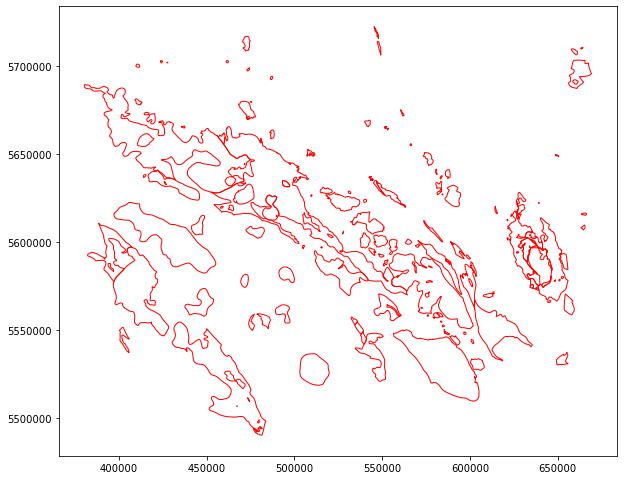

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))
#rioplt.show(granoDistData, ax=ax, cmap='viridis', transform=gTemp.transform)

granodioriteData.plot(categorical=True, legend=True,
                      ax=ax, facecolor='none', edgecolor='r')

# ax.set_xlim(projBounds.bounds['minx'][0], projBounds.bounds['maxx'][0])
# ax.set_ylim(projBounds.bounds['miny'][0], projBounds.bounds['maxy'][0])

In [257]:
dst_crs ='EPSG:26910'
tmpTransform = calculate_default_transform(gTemp.crs, dst_crs, gTemp.width, gTemp.height, *gTemp.bounds)
tmpTransform

(Affine(500.0, 0.0, 491500.0,
        0.0, -500.0, 5730500.0),
 357,
 417)

In [297]:
gTemp.width

357

In [263]:
tmpTransform = rio.transform.Affine.translation(minX - xRes / 2, minY - yRes / 2) * rio.transform.Affine.scale(xRes, -yRes)
tmpTransform

Affine(500.0, 0.0, 491250.0,
       0.0, -500.0, 5521750.0)

In [285]:
ranpointXY = shp.geometry.Point(550100, 5635000)
ranpointXY2 = shp.geometry.Point(602321, 5671000)
mpXY = shp.geometry.MultiPoint([ranpointXY, ranpointXY2])
rpoints = gpd.GeoSeries(mpXY)

In [287]:
print(granodioriteData2.distance(ranpointXY))
print(ultramaficData2.distance(ranpointXY))

0    2204.259444
dtype: float64
0    1754.261134
dtype: float64


In [288]:
row, col = gTemp.index(550100, 5635000)
row, col

(226, 117)

In [293]:
tPoint = gTemp.xy(row, col)
print(tPoint)
print(granodioriteData2.distance(shp.geometry.Point(tPoint)))

(550250.0, 5635250.0)
0    2495.40625
dtype: float64


In [294]:
granoDistData[row, col]

19121.574300457956

In [295]:
granoDistData[col, row]

14475.18124717797

(5522125.101269139, 5730939.986451083)

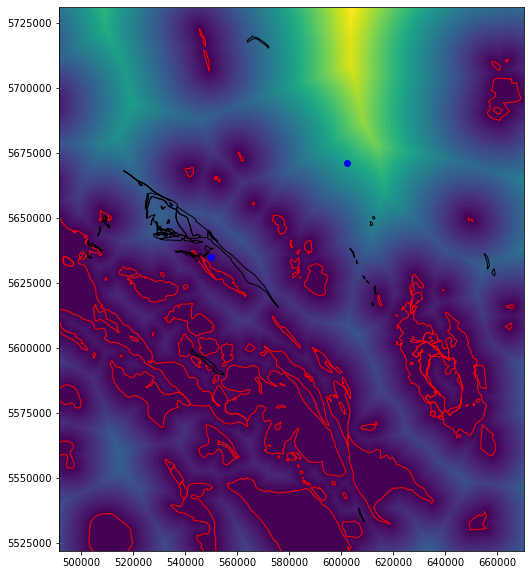

In [326]:
fig, ax = plt.subplots(figsize=(10, 10))
#rioplt.show(gTemp.read(1), ax=ax, cmap='viridis', transform=dTransform)
rioplt.show(granoDistData, ax=ax, cmap='viridis', transform=dataTransform)
granodioriteData.plot(categorical=True, legend=True,
                      ax=ax, facecolor='none', edgecolor='r')
ultramaficData.plot(categorical=True, legend=True,
                      ax=ax, facecolor='none', edgecolor='black')
rpoints.plot(ax=ax, color='blue')
ax.set_xlim(projBounds.bounds['minx'][0], projBounds.bounds['maxx'][0])
ax.set_ylim(projBounds.bounds['miny'][0], projBounds.bounds['maxy'][0])

(5522125.101269139, 5730939.986451083)

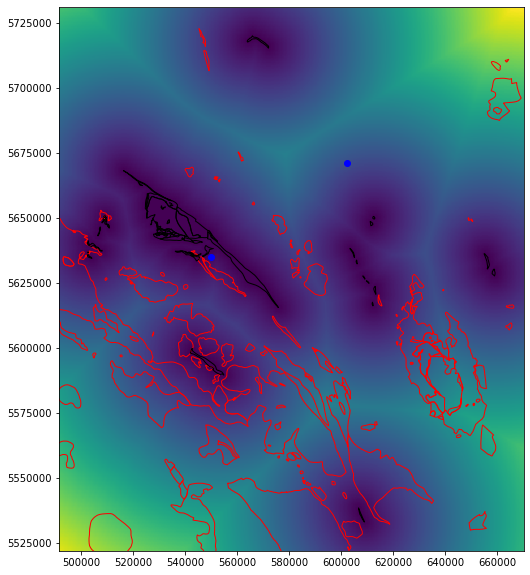

In [328]:
fig, ax = plt.subplots(figsize=(10, 10))
#rioplt.show(gTemp.read(1), ax=ax, cmap='viridis', transform=dTransform)
rioplt.show(umDistData, ax=ax, cmap='viridis', transform=dataTransform)
granodioriteData.plot(categorical=True, legend=True,
                      ax=ax, facecolor='none', edgecolor='r')
ultramaficData.plot(categorical=True, legend=True,
                      ax=ax, facecolor='none', edgecolor='black')
rpoints.plot(ax=ax, color='blue')
ax.set_xlim(projBounds.bounds['minx'][0], projBounds.bounds['maxx'][0])
ax.set_ylim(projBounds.bounds['miny'][0], projBounds.bounds['maxy'][0])

In [45]:
ranpointXY = shp.geometry.Point(612321, 5675000)
ranpointXY2 = shp.geometry.Point(602321, 5671000)

In [46]:
mpXY = shp.geometry.MultiPoint([ranpointXY, ranpointXY2])
print(mpXY)

MULTIPOINT (612321 5675000, 602321 5671000)


In [47]:
rpoints = gpd.GeoSeries(mpXY)

In [48]:
gs1 = gpd.GeoSeries(ranpointXY)

In [49]:
gs1Buff = gs1.buffer(41535)

In [50]:
ptsBuffer = rpoints

In [51]:
print(granodioriteData2.distance(ranpointXY))
print(granodioriteData2.distance(ranpointXY2))

0    41535.467016
dtype: float64
0    32568.449264
dtype: float64


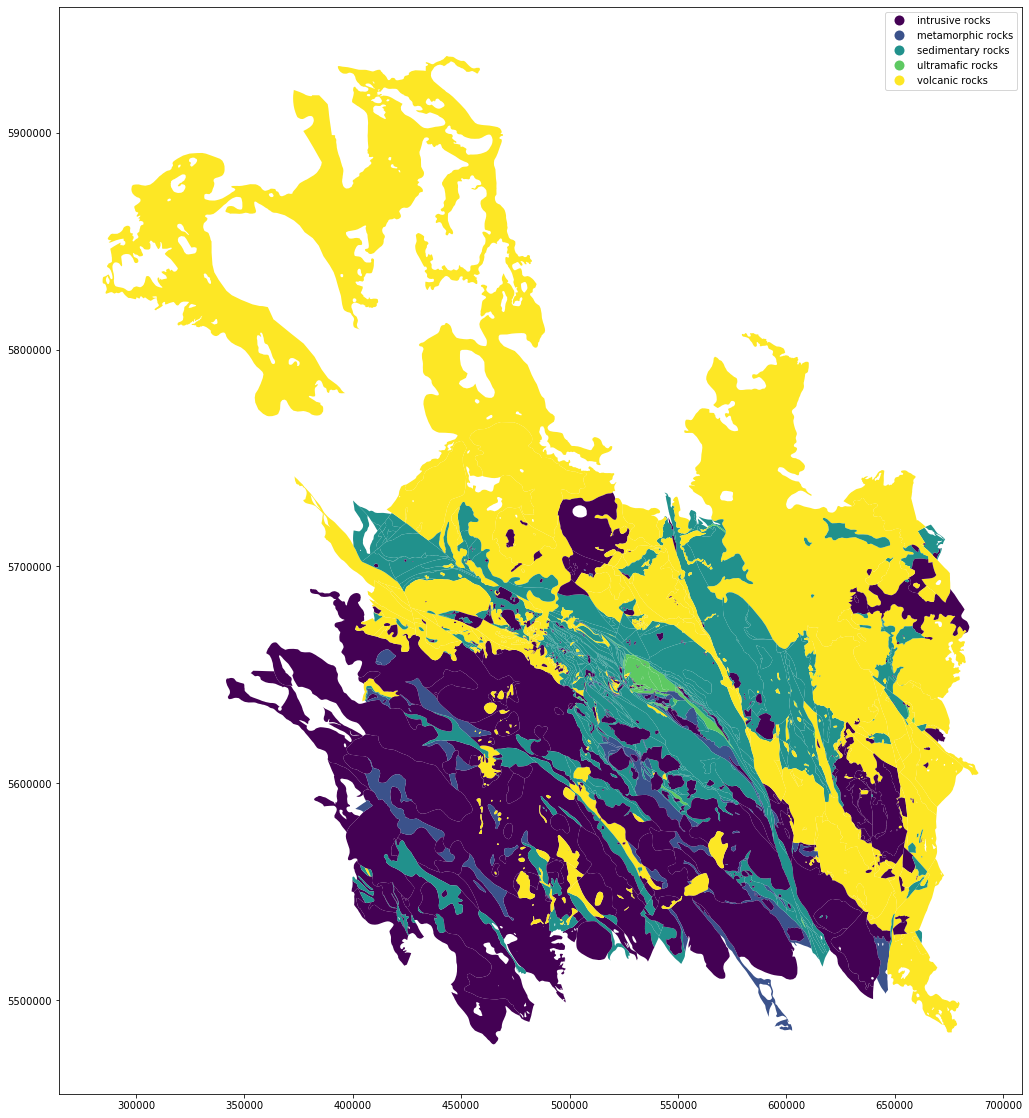

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
bedrock_data.plot(column="rock_class", categorical=True, legend=True,
                           ax=ax, cmap='viridis')

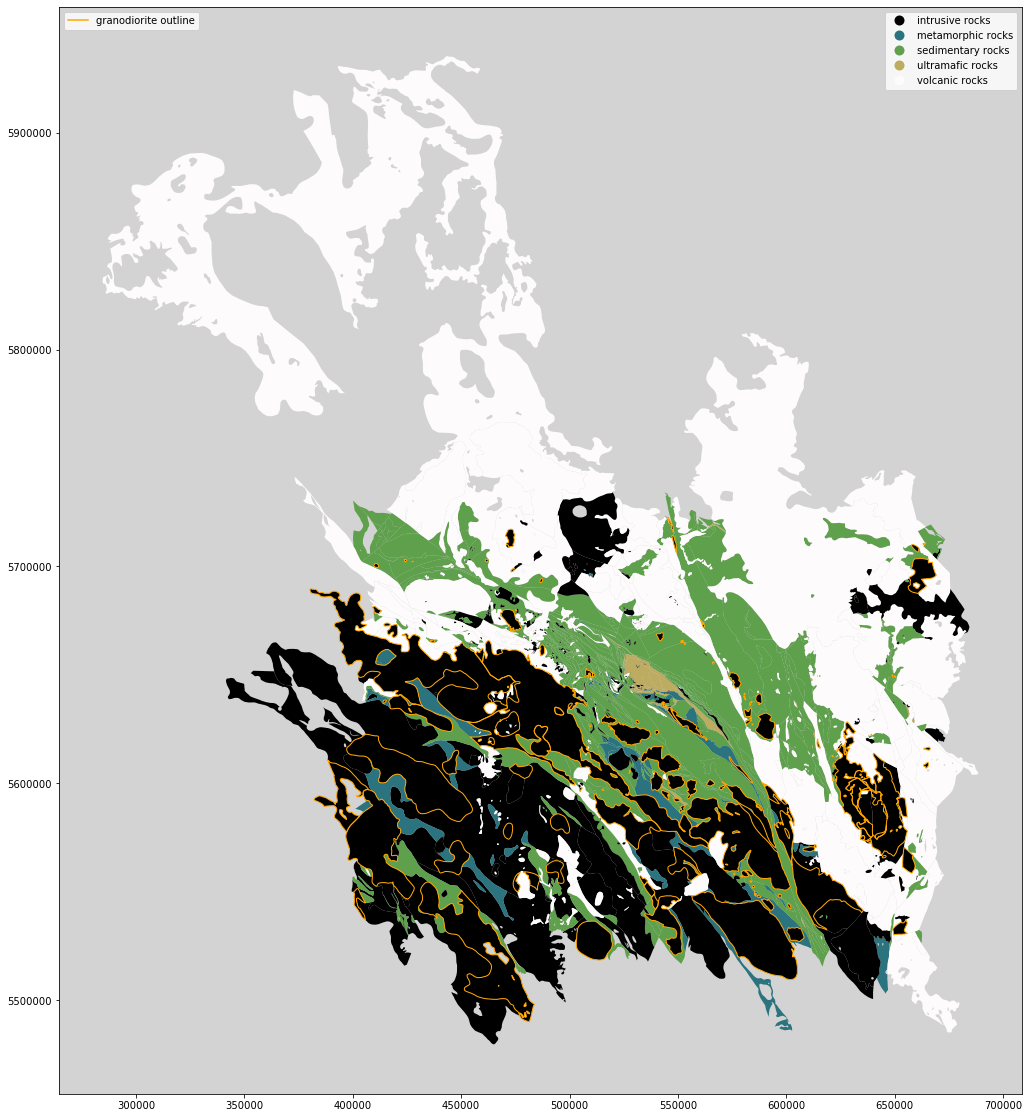

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
bedrock_data.plot(column="rock_class", categorical=True, legend=True,
                           ax=ax, cmap='gist_earth')
granodioriteData.plot(categorical=True, legend=False,
                      ax=ax, color='none', edgecolor='orange')
from matplotlib.legend import Legend
granoleg = ax.plot([], color='orange')
leg = Legend(ax, granoleg, ['granodiorite outline'],
             loc='upper left', frameon=True)
ax.add_artist(leg)
ax.set_facecolor('lightgrey')

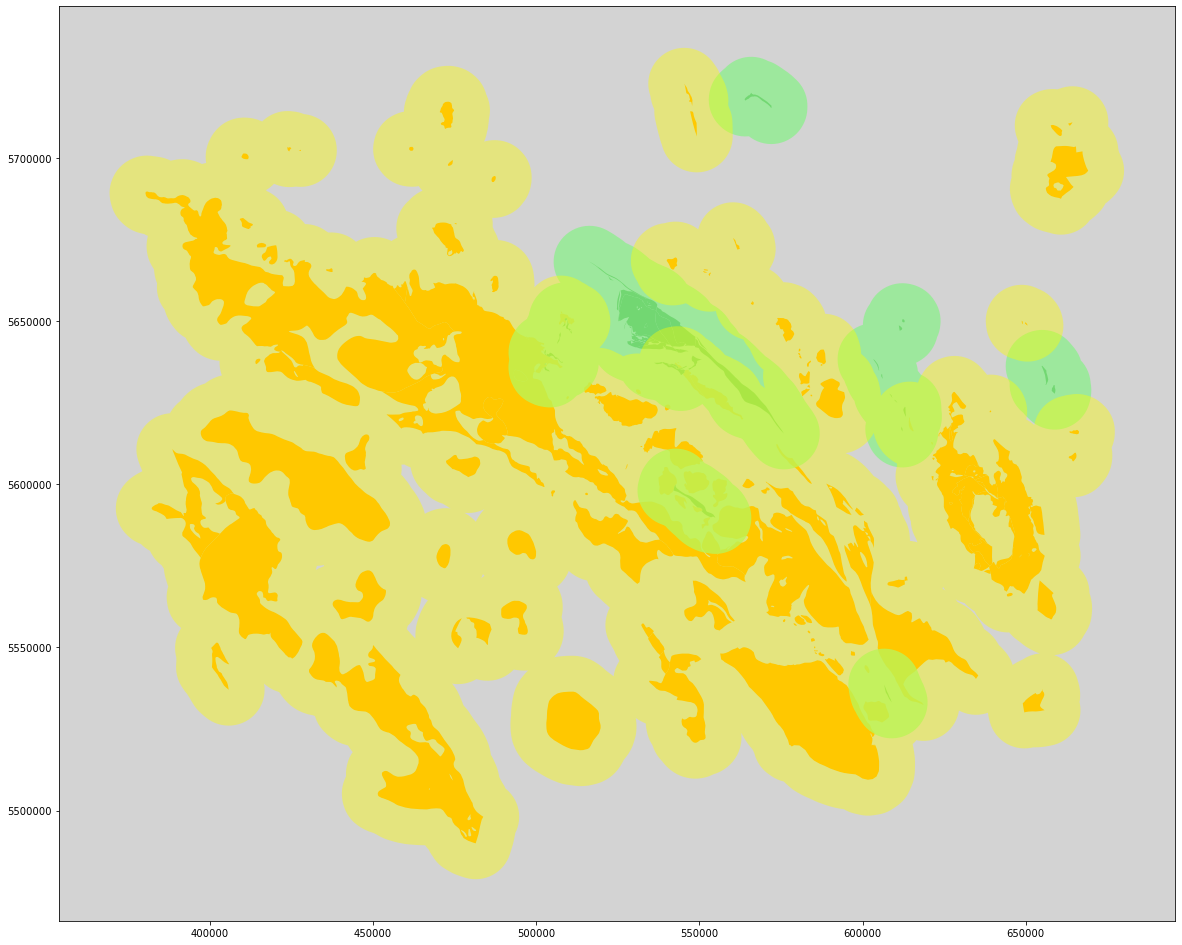

In [54]:
fig, ax = plt.subplots(figsize=(20,20))
granodioriteData.plot(categorical=True, legend=True,
                      ax=ax, color='orange')
ultramaficData.plot(categorical=True, legend=True,
                    ax=ax, color='green')
ultumBuffer11K.plot(color='lightgreen', ax=ax, alpha=0.8)
granoBuffer11K.plot(color='yellow', ax=ax, alpha=0.4)
ax.set_facecolor('lightgrey')

(5522125.101269139, 5730939.986451083)

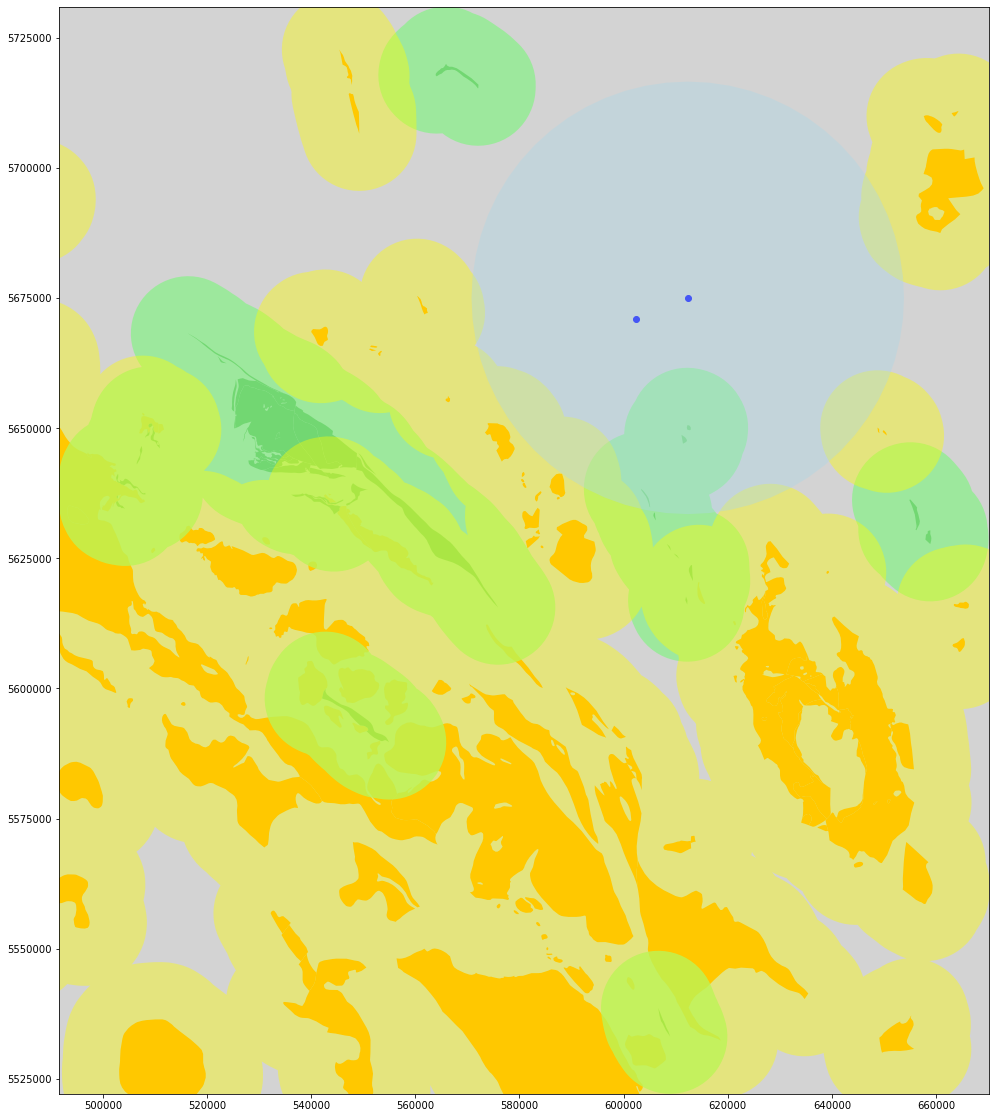

In [58]:
fig, ax = plt.subplots(figsize=(20,20))
granodioriteData.plot(categorical=True, legend=True,
                      ax=ax, color='orange')
ultramaficData.plot(categorical=True, legend=True,
                    ax=ax, color='green')
ultumBuffer11K.plot(color='lightgreen', ax=ax, alpha=0.8)
granoBuffer11K.plot(color='yellow', ax=ax, alpha=0.4)
rpoints.plot(ax=ax, color='blue')
gs1Buff.plot(ax=ax, color='lightblue', alpha=0.4)
ax.set_facecolor('lightgrey')
ax.set_xlim(projBounds.bounds['minx'][0], projBounds.bounds['maxx'][0])
ax.set_ylim(projBounds.bounds['miny'][0], projBounds.bounds['maxy'][0])

In [70]:
bound.bounds

,minx,miny,maxx,maxy
0,491522.194408,5.522125e+06,670103.434455,5.730940e+06


In [73]:
bound.bounds['minx'][0]

491522.19440763723

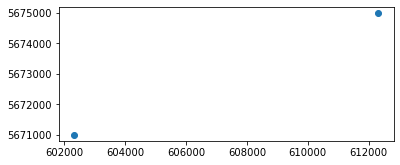

In [78]:
rpoints.plot()